In [3]:
# SETUP INSTRUCTIONS
# Run each cell below to set up environment
# Make sure to adjust subjectid and path variables
# Run pupillabs test BEFORE this protocol to ensure measurements are as expected
path_base = 'C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata/'
# can add subject number + date
subj_base = 'pipr-sub-003_ses-01_dat-20230705' # pipr-sub-subjectID-ses-sesID-dat-date - sub-xxx-ses-xx-dat-yyyymmdd

In [2]:
# Set up stlab
from pyplr import stlab
d = stlab.SpectraTuneLab(password='2294b16eea08a15a')

LIGHT HUB login success
User authenticated as: admin
The following addresses are defined: [1, 1004, 1023]
Call get_luminaires() / get_device_info() for more info


Light engine is now set up, and so it is now possible to access the methods from the REST API. 

C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:368: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for led, df in self.data.groupby(["led"]):
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lkp_tbl = lkp_tbl.append(self.interp_led_spectra(led, df))
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lkp_tbl = lkp_tbl.append(self.interp_led_spectra(led, df))
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is de

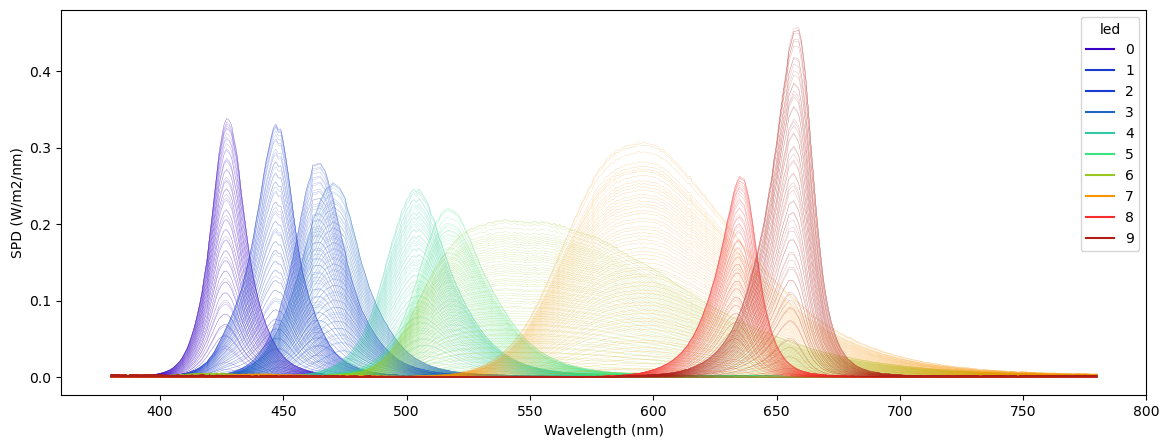

In [4]:
# from pyplr.calibrate import CalibrationContext as calibrationContext
# Calibration - important
import pyplr.calibrate as calb
from importlib import reload
reload(calb)
# file type to be read must be in format of:
# led | intensity | wavelength 1 (380) | wavelength 2 | ... | wavelength n (780)

cc = calb.CalibrationContext(
    'S2_corrected_oo_spectra.csv', binwidth=1)
_ = cc.plot_calibrated_spectra()


In [5]:
# calculate the peak spectral sensitivity for each LED at its maximum intensity setting
cc.lkp.xs(key=4095, level=1).idxmax(axis=1)

led
0    427
1    447
2    465
3    470
4    505
5    517
6    540
7    594
8    635
9    659
dtype: int64

In [6]:
blue_led = 3
red_led = 9
target_lux = 800

# Find the required intensity setting of the blue led for 800 lux
blue_intensity = (cc.lux.loc[blue_led].sub(target_lux)
                                      .abs()
                                      .idxmin())
#                                     .values[0])

# Find the intensity setting of the red led for 800 lux
red_intensity = cc.match(match_led=blue_led,
                         match_led_intensity=blue_intensity,
                         target_led=red_led,
                         match_type='irrad')[1]

C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\CIE.py:5908: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  sss.index = pd.Int64Index(sss.index)


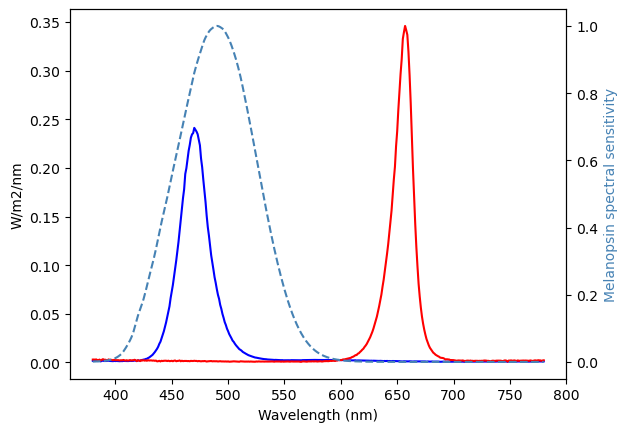

In [7]:
import matplotlib.pyplot as plt
from pyplr.CIE import get_CIES026

fig, ax = plt.subplots()
sss = get_CIES026(binwidth=1)
ax.plot(cc.lkp.loc[(blue_led, blue_intensity)], c='blue')
ax.plot(cc.lkp.loc[(red_led, red_intensity)], c='red')

ax2 = ax.twinx()
ax2.plot(sss['I'], ls='dashed', c='steelblue') # melanopsin = "I"
ax2.set_ylabel('Melanopsin spectral sensitivity', c='steelblue')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('W/m2/nm');

In [8]:
from pyplr import stlab

blue_spec, red_spec = [0]*10, [0]*10
blue_spec[blue_led] = blue_intensity
red_spec[red_led] = red_intensity



In [9]:
from time import sleep
# import random # not using this library unless we want to randomize stims
from pyplr.pupil import PupilCore
from pyplr.utils import unpack_data_pandas
from pyplr.protocol import input_subject_id, subject_dir
# Connect to Pupil Core
p = PupilCore()
p.check_3d_model()

> Refit the 3d model? [y/n]: y
> Unfreezing 3d model for eye 0
> Unfreezing 3d model for eye 1
> Ask the participant to roll their eyes
> Press "Enter" when ready to freeze the model: 
> Freezing 3d model for eye 0
> Freezing 3d model for eye 1


Please enter subject ID: 999
> Grabbing 420 seconds of pupil.1.3d
> Waiting for a light to stamp...
> Light stamped on frame.world at 689970.0772810001
> Waiting for a light to stamp...
> Light stamped on frame.world at 690036.3856500001
> Waiting for a light to stamp...
> Light stamped on frame.world at 690102.918729
> Waiting for a light to stamp...
> Light stamped on frame.world at 690169.428877
> Waiting for a light to stamp...
> Light stamped on frame.world at 690235.923252
> Waiting for a light to stamp...
> Light stamped on frame.world at 690302.5674930001
> PupilGrabber done grabbing 420 seconds of pupil.1.3d
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting

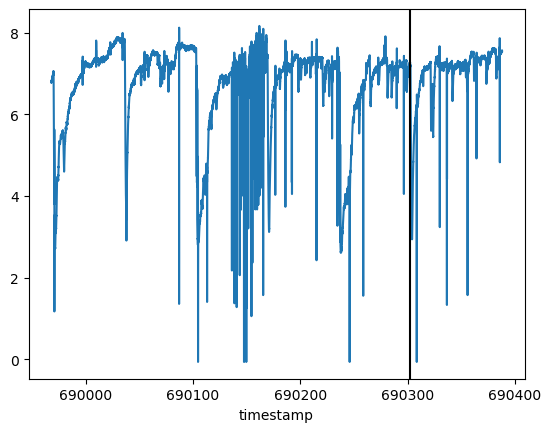

In [11]:
# PIPR STIMS - USE THIS ONE
d.turn_off()
subject_id = input_subject_id()
subj_dir = subject_dir(subject_id)
sleep(2)
ISI = 60 # interstimulus time (seconds) = this variable + 5s due to sleep + processing
num_trials = 6 # total number of trials
run_time = ISI*num_trials + 5*num_trials + 30 # appropriate offset to account for stim duration + sleeps


# Start a new recording called "my_recording"
p.command('R my_recording')

# Wait a few seconds
sleep(2)

# Make an annotation for when the light comes on
annotation = p.new_annotation('LIGHT_ON')

# Start the .light_stamper(...) and .pupil_grabber(...)
# this only captures one eye
# pgr_future = p.pupil_grabber(topic='pupil.1.3d', seconds=25) # time here is TOTAL run time
pgr_future = p.pupil_grabber(topic='pupil.1.3d', seconds=run_time) # time here is TOTAL run time

sleep(2)
##################################
# Administer light stimulus here #
led_list = [3,9]*3
# random.shuffle(led_list) # use this if stims should be randomized
for led in led_list:
    intensities = [0]*10
    if led == 3:
        intensities[led] = int(blue_intensity)
    else:
        intensities[led] = int(red_intensity)
    lst_future = p.light_stamper(annotation=annotation, timeout=10)
    d.set_spectrum_a(intensities)
    sleep(1.)
    d.turn_off()
    sleep(ISI)
    sleep(5) # make sure there is extra time so that trials do not overlap
##################################

# Wait for the futures
while lst_future.running() or pgr_future.running():
    print('Waiting for futures...')
    sleep(1)

# End recording
p.command('r')

# Get the timestamp and pupil data
timestamp = lst_future.result()[1]
data = unpack_data_pandas(pgr_future.result())
# timestamps are displayed in the output as well
# Plot the PLR
ax = data['diameter_3d'].plot()
ax.axvline(x=timestamp, color='k')

In [12]:
# display data from pandas table
data

,id,topic,method,norm_pos,diameter,confidence,sphere,projected_sphere,circle_3d,diameter_3d,ellipse,location,model_confidence,theta,phi
timestamp,,,,,,,,,,,,,,,
689967.984596,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.20361037625955, 0.7530851384722497]",61.389403,1.000000,"{'center': [-0.8164332879972208, -2.8670409782...","{'center': [90.54456774805384, 77.298450900953...","{'center': [-6.639541985225864, -5.77096502644...",6.793062,"{'center': [39.0931922418336, 47.4076534133280...","[39.0931922418336, 47.40765341332806]",1.0,1.853997,-2.193921
689968.004282,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.20353616995592386, 0.7532737080481252]",61.460563,0.981768,"{'center': [-0.8164332879972208, -2.8670409782...","{'center': [90.54456774805384, 77.298450900953...","{'center': [-6.641884085441343, -5.77565053033...",6.801884,"{'center': [39.07894463153738, 47.371448054759...","[39.07894463153738, 47.37144805475995]",1.0,1.854467,-2.194308
689968.016404,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.20330347014290898, 0.7530380893957275]",61.429566,1.000000,"{'center': [-0.8164332879972208, -2.8670409782...","{'center': [90.54456774805384, 77.298450900953...","{'center': [-6.64717374051695, -5.770569721978...",6.798385,"{'center': [39.034266267438525, 47.41668683602...","[39.034266267438525, 47.41668683602032]",1.0,1.853957,-2.194854
689968.033182,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.2035126036809631, 0.7530476506673836]",61.402353,0.992929,"{'center': [-0.8164332879972208, -2.8670409782...","{'center': [90.54456774805384, 77.298450900953...","{'center': [-6.641951332138455, -5.77031575735...",6.794758,"{'center': [39.074419906744914, 47.41485107186...","[39.074419906744914, 47.41485107186236]",1.0,1.853932,-2.194204
689968.053564,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.2035461832169336, 0.7527136287452117]",61.417158,0.978470,"{'center': [-0.8164332879972208, -2.8670409782...","{'center': [90.54456774805384, 77.298450900953...","{'center': [-6.640873109347274, -5.76250753385...",6.796208,"{'center': [39.08086717765125, 47.478983280919...","[39.08086717765125, 47.47898328091934]",1.0,1.853149,-2.193908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690387.908987,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.19524187624726527, 0.6988433989483698]",67.714378,0.903426,"{'center': [-0.8164332879972208, -2.8670409782...","{'center': [90.54456774805384, 77.298450900953...","{'center': [-6.839686775505668, -4.55099263566...",7.542373,"{'center': [37.48644023947493, 57.822067401912...","[37.48644023947493, 57.822067401912996]",1.0,1.733552,-2.198577
690387.931396,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.19524794808222914, 0.6990658638274061]",67.634374,0.956698,"{'center': [-0.8164332879972208, -2.8670409782...","{'center': [90.54456774805384, 77.298450900953...","{'center': [-6.83911010468325, -4.555918661676...",7.532607,"{'center': [37.487606031788, 57.77935414513804...","[37.487606031788, 57.77935414513804]",1.0,1.734033,-2.198565
690387.951175,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.19535554521146595, 0.699117815675022]",67.911665,0.870848,"{'center': [-0.8164332879972208, -2.8670409782...","{'center': [90.54456774805384, 77.298450900953...","{'center': [-6.8383969724073514, -4.5573871476...",7.566610,"{'center': [37.508264680601464, 57.76937939039...","[37.508264680601464, 57.76937939039577]",1.0,1.734176,-2.198496


In [13]:
import os  

# os.makedirs('C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata', exist_ok=True) 

data.to_csv(path_base + subj_base + '.csv')

**DATA PROCESSING BEGINS BELOW**

In [14]:
new_data = data[['confidence','id','diameter','diameter_3d']]

In [15]:
samples = new_data
samples

,confidence,id,diameter,diameter_3d
timestamp,,,,
689967.984596,1.000000,1,61.389403,6.793062
689968.004282,0.981768,1,61.460563,6.801884
689968.016404,1.000000,1,61.429566,6.798385
689968.033182,0.992929,1,61.402353,6.794758
689968.053564,0.978470,1,61.417158,6.796208
...,...,...,...,...
690387.908987,0.903426,1,67.714378,7.542373
690387.931396,0.956698,1,67.634374,7.532607
690387.951175,0.870848,1,67.911665,7.566610


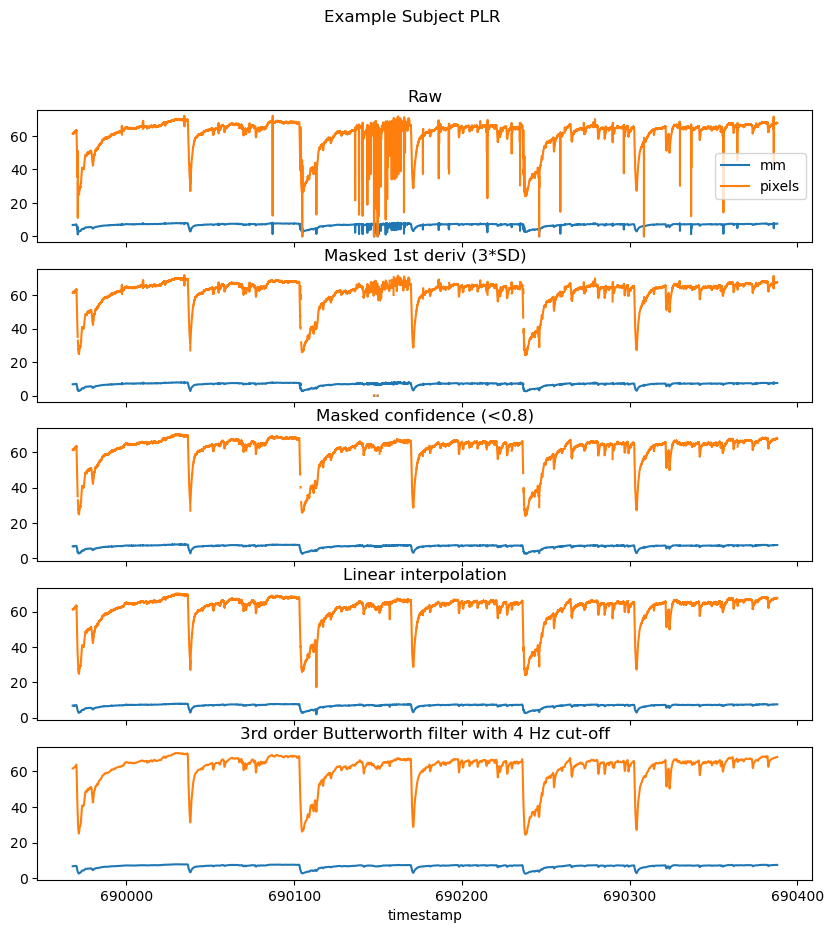

In [16]:
from pyplr import graphing
from pyplr import preproc

# Sampling frequency
SAMPLE_RATE = 120

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Example Subject PLR')

# Plot the raw data
samples[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples = preproc.mask_pupil_first_derivative(
    samples, threshold=3.0, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples = preproc.mask_pupil_confidence(
    samples, threshold=0.8, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples = preproc.interpolate_pupil(
    samples, interp_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples = preproc.butterworth_series(
    samples, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [19]:
# Read in csv file and extract the column with header "CVR"
# df_pipr = pd.read_csv("C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata/sub-999_ses-02_dat-20230419.csv")
df_pipr = pd.read_csv(path_base + subj_base + '.csv')

# Print header names
print(df_pipr.columns)

# Extract the column with header "CVR"
timestamps = df_pipr["timestamp"]
# Extract the column with header "CVR_SI"
diam_3d = df_pipr["diameter_3d"]

Index(['timestamp', 'id', 'topic', 'method', 'norm_pos', 'diameter',
       'confidence', 'sphere', 'projected_sphere', 'circle_3d', 'diameter_3d',
       'ellipse', 'location', 'model_confidence', 'theta', 'phi'],
      dtype='object')


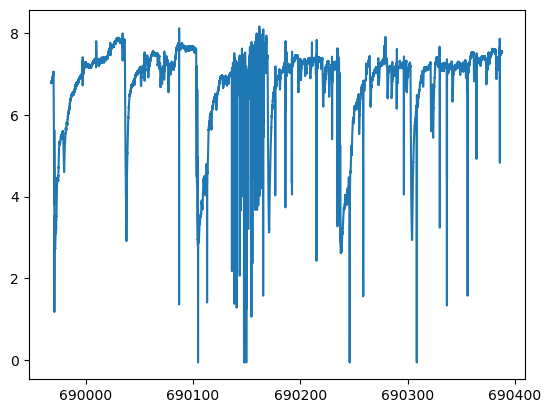

In [20]:
fig = plt.figure()
plt.plot(timestamps, diam_3d)

This is copied from the output of cell 11
> Light stamped on frame.world at 689970.0772810001
> Waiting for a light to stamp...
> Light stamped on frame.world at 690036.3856500001
> Waiting for a light to stamp...
> Light stamped on frame.world at 690102.918729
> Waiting for a light to stamp...
> Light stamped on frame.world at 690169.428877
> Waiting for a light to stamp...
> Light stamped on frame.world at 690235.923252
> Waiting for a light to stamp...
> Light stamped on frame.world at 690302.5674930001

**Edit Cell Below with Timestamps**

In [21]:
# NEED TO EDIT THIS WITH NEW TIMESTAMPS
# finds indices of each timestamp (or closest one before, if exact match cannot be found).
# finds list of timestamps where condition is true, extracts array of just this, then takes last value (closest stamp)
stamp1 = np.where(timestamps <= 689970.0772810001)[0][-1]
stamp2 = np.where(timestamps <= 690036.3856500001)[0][-1]
stamp3 = np.where(timestamps <= 690102.918729)[0][-1]
stamp4 = np.where(timestamps <= 690169.428877)[0][-1]
stamp5 = np.where(timestamps <= 690235.923252)[0][-1]
stamp6 = np.where(timestamps <= 690302.5674930001)[0][-1]
stamps = [stamp1, stamp2, stamp3, stamp4, stamp5, stamp6]
stamps

[117, 3691, 7300, 10635, 14077, 17538]

In [22]:
from pyplr import utils
from copy import deepcopy

In [23]:
df_data = df_pipr[['timestamp', 'confidence','id','diameter','diameter_3d']]
df_data

,timestamp,confidence,id,diameter,diameter_3d
0,689967.984596,1.000000,1,61.389403,6.793062
1,689968.004282,0.981768,1,61.460563,6.801884
2,689968.016404,1.000000,1,61.429566,6.798385
3,689968.033182,0.992929,1,61.402353,6.794758
4,689968.053564,0.978470,1,61.417158,6.796208
...,...,...,...,...,...
21466,690387.908987,0.903426,1,67.714378,7.542373
21467,690387.931396,0.956698,1,67.634374,7.532607
21468,690387.951175,0.870848,1,67.911665,7.566610
21469,690387.970787,0.977981,1,67.946689,7.571416


In [24]:
# extract ranges from samples based on event timing and sample count
# adapted from extract() from utils.py
# set variables - change as necessary
samples = df_data
event_starts = stamps 
onset_time = 1
duration_time = 60
offset = -60*onset_time # 60 sample rate, start 1s before light to get baseline
duration = 60*duration_time  # 60 sample rate

# find the indexes of the event starts, and offset by sample count
range_idxs = (
    np.searchsorted(samples.index, event_starts, "left") + offset
)
range_duration = duration


In [25]:
range_idxs

array([   57,  3631,  7240, 10575, 14017, 17478], dtype=int64)

In [26]:
# make a hierarchical index
samples["orig_idx"] = samples.index
midx = pd.MultiIndex.from_product(
    [list(range(len(event_starts))), list(range(range_duration))],
    names=["event", "onset"],
)

# TODO: can add option for time index here

# get the samples
df = pd.DataFrame()
idx = 0
for start_idx in range_idxs:
    # get the start time and add the required number of indices
    end_idx = start_idx + range_duration - 1  # .loc indexing is inclusive
    if end_idx >= len(samples):
        end_idx = len(samples) - 1
    new_df = deepcopy(
        samples.loc[samples.index[start_idx] : samples.index[end_idx]]
    )
    #for ba in borrow_attributes:
        #new_df[ba] = events.iloc[idx].get(ba, float("nan"))
    df = pd.concat([df, new_df])
    idx += 1
df.index = midx
print("Extracted ranges for {} events".format(len(event_starts)))

Extracted ranges for 6 events


C:\Users\kebl6975\AppData\Local\Temp\ipykernel_36548\2016008756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples["orig_idx"] = samples.index


In [27]:
df.index

MultiIndex([(0,    0),
            (0,    1),
            (0,    2),
            (0,    3),
            (0,    4),
            (0,    5),
            (0,    6),
            (0,    7),
            (0,    8),
            (0,    9),
            ...
            (5, 3590),
            (5, 3591),
            (5, 3592),
            (5, 3593),
            (5, 3594),
            (5, 3595),
            (5, 3596),
            (5, 3597),
            (5, 3598),
            (5, 3599)],
           names=['event', 'onset'], length=21600)

In [28]:
from pyplr import graphing
from pyplr import preproc
# Calculate baselines
baselines = df.loc[:, range(0, -offset), :].mean(level=0)

# New columns for percent signal change
df = preproc.percent_signal_change(
    df, baselines, ['diameter_3d', 'diameter'])
df


C:\Users\kebl6975\AppData\Local\Temp\ipykernel_36548\2404135914.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  baselines = df.loc[:, range(0, -offset), :].mean(level=0)


timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      689969.012534    0.999656   1  61.996480     6.868490        57   
      1      689969.031796    0.999904   1  61.923981     6.857779        58   
      2      689969.050745    0.983989   1  62.029771     6.870434        59   
      3      689969.063570    0.942364   1  61.933063     6.859060        60   
      4      689969.082726    0.950674   1  62.184343     6.889556        61   
...                    ...         ...  ..        ...          ...       ...   
5     3595   690379.523805    0.966725   1  68.223894     7.612237     21073   
      3596   690379.540857    0.941435   1  68.186522     7.607425     21074   
      3597   690379.562533    0.994952   1  68.216086     7.611046     21075   
      3598   690379.584044    0.944150   1  68.028559     7.587172     21076   
      3599   690379.604336    0.957176   1  68.196947     7.607872     21077   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0           -0.939540    -0.864253  
      1           -1.094010    -0.980183  
      2           -0.911495    -0.811019  
      3           -1.075545    -0.965660  
      4           -0.635711    -0.563849  
...                     ...          ...  
5     3595         5.481062     4.908184  
      3596         5.414393     4.850716  
      3597         5.464563     4.896178  
      3598         5.133746     4.607817  
      3599         5.420584     4.866747  

[21600 rows x 8 columns]

In [29]:
from pyplr.plr import PLR

average_plr = df.mean(level=1)['diameter_3d'].to_numpy()
plr = PLR(average_plr,
          sample_rate=60,
          onset_idx=-offset,
          stim_duration=1)

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_36548\2953176601.py:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  average_plr = df.mean(level=1)['diameter_3d'].to_numpy()


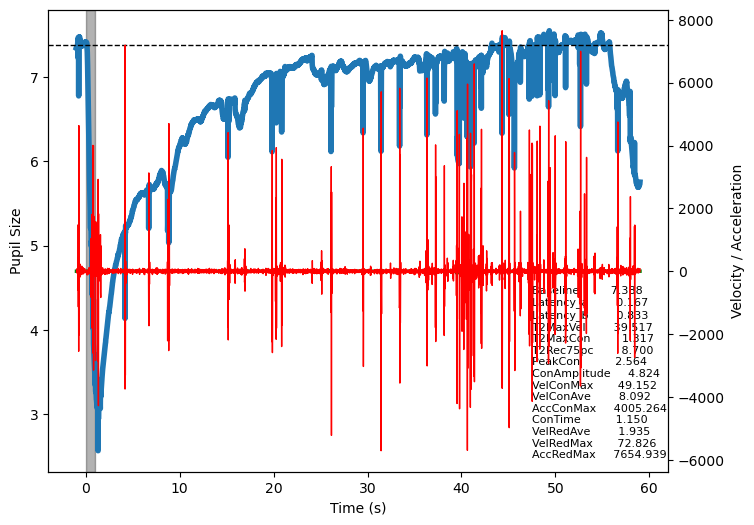

In [30]:
fig = plr.plot(vel=True, acc=True, print_params=True)

In [31]:
params = plr.parameters()
params

,value
Baseline,7.388010
Latency_a,0.166667
Latency_b,0.833333
T2MaxVel,39.516667
T2MaxCon,1.316667
T2Rec75pc,8.700000
PeakCon,2.563990
ConAmplitude,4.824020
VelConMax,49.151859
VelConAve,8.092468


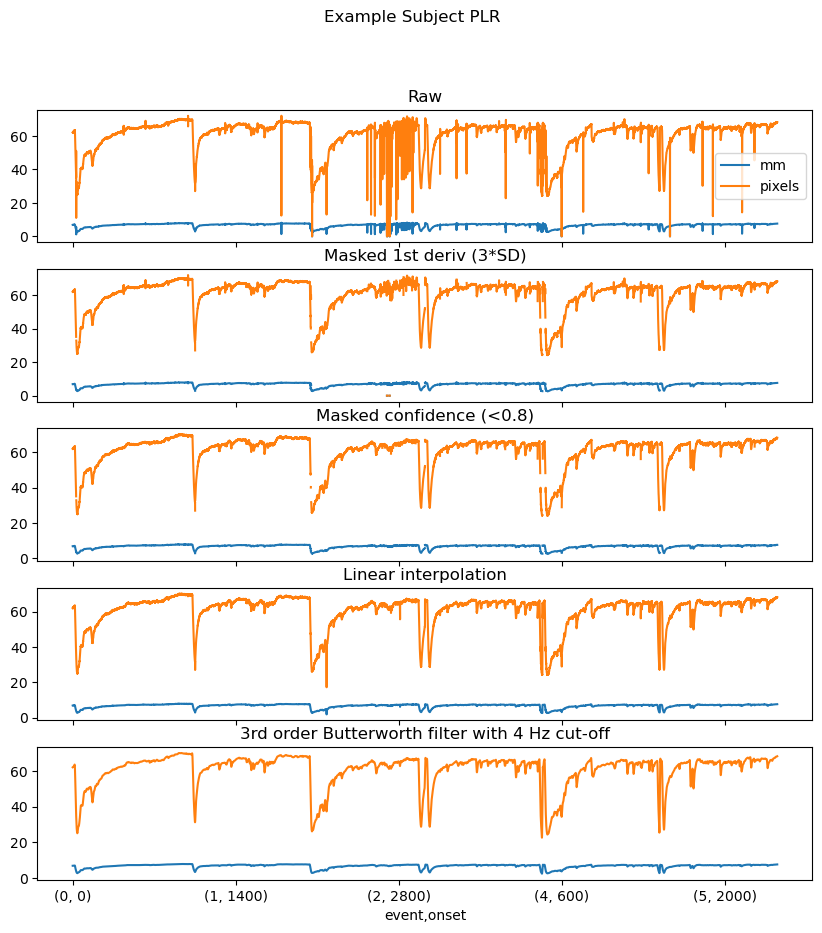

In [32]:
from pyplr import graphing
from pyplr import preproc

# Sampling frequency
SAMPLE_RATE = 120
samples = df

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Example Subject PLR')

# Plot the raw data
samples[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples = preproc.mask_pupil_first_derivative(
    samples, threshold=3.0, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples = preproc.mask_pupil_confidence(
    samples, threshold=0.8, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples = preproc.interpolate_pupil(
    samples, interp_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples = preproc.butterworth_series(
    samples, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [34]:
samples # this now has the processed data with blinks removed
# where confidence < 0.8, it interpolates the data
# need to run these to improve the outputs
# TODO: double check what df is after this processing

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      689969.012534    0.999656   1  61.993133     6.868003        57   
      1      689969.031796    0.999904   1  62.015759     6.870447        58   
      2      689969.050745    0.983989   1  62.037382     6.872778        59   
      3      689969.063570    0.942364   1  62.057843     6.874981        60   
      4      689969.082726    0.950674   1  62.077027     6.877048        61   
...                    ...         ...  ..        ...          ...       ...   
5     3595   690379.523805    0.966725   1  68.104300     7.596877     21073   
      3596   690379.540857    0.941435   1  68.119497     7.598623     21074   
      3597   690379.562533    0.994952   1  68.134975     7.600413     21075   
      3598   690379.584044    0.944150   1  68.150273     7.602190     21076   
      3599   690379.604336    0.957176   1  68.164957     7.603902     21077   

             diameter_3d_pc  diameter_pc  interpolated  
event onset                                             
0     0           -0.939540    -0.864253             0  
      1           -1.094010    -0.980183             0  
      2           -0.911495    -0.811019             0  
      3           -1.075545    -0.965660             0  
      4           -0.635711    -0.563849             0  
...                     ...          ...           ...  
5     3595         5.481062     4.908184             0  
      3596         5.414393     4.850716             0  
      3597         5.464563     4.896178             0  
      3598         5.133746     4.607817             0  
      3599         5.420584     4.866747             0  

[21600 rows x 9 columns]

In [35]:
df

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      689969.012534    0.999656   1  61.996480     6.868490        57   
      1      689969.031796    0.999904   1  61.923981     6.857779        58   
      2      689969.050745    0.983989   1  62.029771     6.870434        59   
      3      689969.063570    0.942364   1  61.933063     6.859060        60   
      4      689969.082726    0.950674   1  62.184343     6.889556        61   
...                    ...         ...  ..        ...          ...       ...   
5     3595   690379.523805    0.966725   1  68.223894     7.612237     21073   
      3596   690379.540857    0.941435   1  68.186522     7.607425     21074   
      3597   690379.562533    0.994952   1  68.216086     7.611046     21075   
      3598   690379.584044    0.944150   1  68.028559     7.587172     21076   
      3599   690379.604336    0.957176   1  68.196947     7.607872     21077   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0           -0.939540    -0.864253  
      1           -1.094010    -0.980183  
      2           -0.911495    -0.811019  
      3           -1.075545    -0.965660  
      4           -0.635711    -0.563849  
...                     ...          ...  
5     3595         5.481062     4.908184  
      3596         5.414393     4.850716  
      3597         5.464563     4.896178  
      3598         5.133746     4.607817  
      3599         5.420584     4.866747  

[21600 rows x 8 columns]

In [36]:
# Convert samples index-level to time (s)
ONSET_IDX = 60
SAMPLE_RATE = 60
new_onset = (df.index.get_level_values('onset')
                    .unique()
            - ONSET_IDX) / SAMPLE_RATE
df.index = df.index.set_levels(
    levels=new_onset, level='onset')

In [39]:
df.keys()

Index(['timestamp', 'confidence', 'id', 'diameter', 'diameter_3d', 'orig_idx',
       'diameter_3d_pc', 'diameter_pc'],
      dtype='object')

In [40]:
df["colour"] = ""

In [41]:
df.keys()

Index(['timestamp', 'confidence', 'id', 'diameter', 'diameter_3d', 'orig_idx',
       'diameter_3d_pc', 'diameter_pc', 'colour'],
      dtype='object')

In [42]:
for (event, onset) in df.index:
    if event%2==1:
        df["colour"][event,onset] = "red"
    else:
        df["colour"][event,onset] = "blue"

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_36548\884742854.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["colour"][event,onset] = "blue"
C:\Users\kebl6975\AppData\Local\Temp\ipykernel_36548\884742854.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["colour"][event,onset] = "red"


Text(0.5, 1.0, 'Subject = 1')

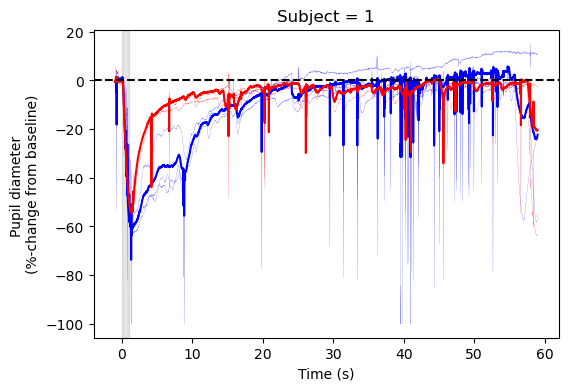

In [43]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,4))
for r in range(5):
    if (r==0 or r%2==0):
        c = 'blue'
    else:
        c = 'red'
    df.loc[r, 'diameter_pc'].plot(
        color=c, lw='.1', ax=ax, legend=False)

# Now show the means
avgs = (df.reset_index()
                .groupby(['colour','onset'], as_index=False)
                .mean())
sns.lineplot(data=avgs, x='onset', y='diameter_pc', hue='colour',
                palette={'blue':'b','red':'r'}, legend=False)

# Tweak figures
ax.axvspan(0, 1, color='k', alpha=.1)
ax.axhline(0, 0, 1, color='k', ls='--')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil diameter \n(%-change from baseline)')
ax.set_title('Subject = {}'.format(df['id'][0][0]))

In [44]:
df # check all is as expected before sending to csv

timestamp  confidence  id   diameter  diameter_3d  \
event onset                                                               
0     -1.000000   689969.012534    0.999656   1  61.996480     6.868490   
      -0.983333   689969.031796    0.999904   1  61.923981     6.857779   
      -0.966667   689969.050745    0.983989   1  62.029771     6.870434   
      -0.950000   689969.063570    0.942364   1  61.933063     6.859060   
      -0.933333   689969.082726    0.950674   1  62.184343     6.889556   
...                         ...         ...  ..        ...          ...   
5      58.916667  690379.523805    0.966725   1  68.223894     7.612237   
       58.933333  690379.540857    0.941435   1  68.186522     7.607425   
       58.950000  690379.562533    0.994952   1  68.216086     7.611046   
       58.966667  690379.584044    0.944150   1  68.028559     7.587172   
       58.983333  690379.604336    0.957176   1  68.196947     7.607872   

                  orig_idx  diameter_3d_pc  diameter_pc colour  
event onset                                                     
0     -1.000000         57       -0.939540    -0.864253   blue  
      -0.983333         58       -1.094010    -0.980183   blue  
      -0.966667         59       -0.911495    -0.811019   blue  
      -0.950000         60       -1.075545    -0.965660   blue  
      -0.933333         61       -0.635711    -0.563849   blue  
...                    ...             ...          ...    ...  
5      58.916667     21073        5.481062     4.908184    red  
       58.933333     21074        5.414393     4.850716    red  
       58.950000     21075        5.464563     4.896178    red  
       58.966667     21076        5.133746     4.607817    red  
       58.983333     21077        5.420584     4.866747    red  

[21600 rows x 9 columns]

In [45]:
df.to_csv(path_base + subj_base + '-processed.csv') # processed data with adjusted onset indices (time in seconds)

<AxesSubplot: xlabel='event,onset'>

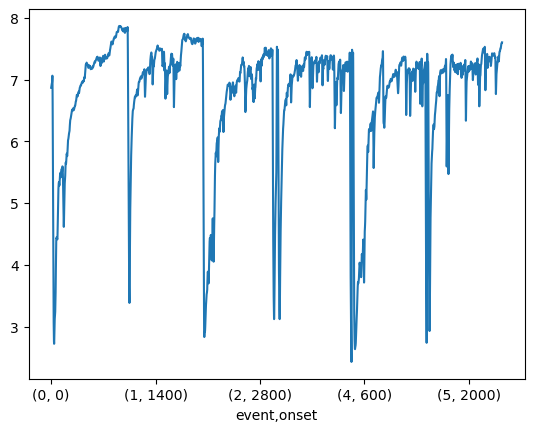

In [47]:
samples["diameter_3d"].plot()

In [48]:
lst_future.result()[1]

690302.5674930001

In [ ]:
avgs.to_csv(path_base + subj_base + '-average-pipr.csv') # processed data with adjusted onset indices (time in seconds)